In [1]:
# ! pip install -e ../../savo

In [2]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import time
# import concurrent
from copy import deepcopy as copy
# def sleep():
#     time.sleep(0.2)
# def clear_output(wait=True):
#     return display.clear_output(wait=wait)

In [3]:
import objFuncs
from objFuncs import VM
from objFuncs.util import plot_obj_history
from savo import savo
from pyBO import pyBO

objFuncs version: 1.0.2. updated on 2023-12-19


flame_utils is not importable. ignoreing this feature...
pyBO version: 1.0.0. updated on 2023-12-14


In [4]:
ndim = 100
latent_ndim = 2
budget = 200
ninit = 50  # number of initial ES steps to collect data for surrogate model training
noise = 0.0

In [5]:
decision_CSETs=['X'+str(i) for i in range(ndim)]
decision_min = -2.5
decision_max =  2.5
x_bounds = np.array([(decision_min,decision_max)]*ndim)
max_dx = np.ones(ndim)*2e-3  # maximum step size each iter
lr = 1e-2

In [6]:
objective_RDs    = ['obj']
objective_goal   = {'obj': {'more than': 1.0}}
objective_norm   = {'obj': 1.0}
objective_weight = {'obj': 1.0}

# obj_func

: rastirigin over 2D latent space of random NN for both high-dim and visualization

In [7]:
import torch
layers = [
    torch.nn.Linear(ndim, 256),torch.nn.ELU(),
    torch.nn.Linear( 256, 256),torch.nn.ELU(),
    torch.nn.Linear( 256,   2)
    ]

torch.nn.init.kaiming_normal_(layers[0].weight, nonlinearity='relu')
torch.nn.init.kaiming_normal_(layers[2].weight, nonlinearity='relu')
torch.nn.init.kaiming_normal_(layers[4].weight, nonlinearity='relu')
with torch.no_grad():
    layers[0].bias.uniform_(-0.1, 0.1)
    layers[2].bias.uniform_(-0.1, 0.1)
#     layers[4].bias.uniform_(-0.1, 0.1)
_compressor_torch = torch.nn.Sequential(*layers)

def compressor(x,ndim=ndim):
    x = torch.tensor(x.reshape(-1,ndim)).to(torch.float32)
    with torch.no_grad():
        z = _compressor_torch(x)
    return z.detach().numpy()


# x = np.random.randn(1024*64,ndim);
x = np.random.rand(1024*64,ndim)*(decision_max-decision_min) + decision_min
y = compressor(x);
y.mean(), y.std()

(-0.11791544, 2.28652)

In [8]:
def rastrigin(x,noise=noise):
    if x.ndim == 1:
        return np.sum(x**2 - np.cos(2*np.pi*x))/len(x)+1
    else:
        b,d = x.shape
        y = np.sum(x**2 - np.cos(2*np.pi*x),axis=1)/d +1
        if d==1:
            return float(y) + np.random.randn()*noise
        else:
            return y + np.random.randn(b)*noise

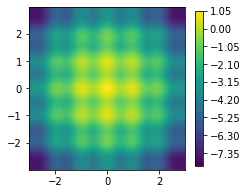

In [9]:
x = np.random.rand(1024*64,2)*6-3
y = 1-rastrigin(x)

fig, ax = plt.subplots(figsize=(3.5,3))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95);
# cs = ax[1].tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
# fig.colorbar(cs,ax=ax[1],shrink=0.95)
# ax[1].set_xlim(-2,2);
# ax[1].set_ylim(-2,2);
# fig.tight_layout()

In [10]:
# inverse rastirigin for maximization problem.  
def obj_function_raw(x):
    x = np.array(x).reshape(-1,ndim)
    return 1-rastrigin(compressor(x))  # global optimum value is 1.
#     return 1-rastrigin(x)            # global optimum value is 1.

# objective function in Virtual EPICS machine using obj_function_raw

In [11]:
vm = VM(
        fun = obj_function_raw,
        decision_CSETs = decision_CSETs,
        objective_RDs  = objective_RDs,
        x0 = np.zeros(ndim)
        );

In [12]:
objFuncs._global_machineIO.ensure_set = vm.ensure_set
objFuncs._global_machineIO.fetch_data = vm.fetch_data
objFuncs._global_machineIO._test = True

In [13]:
obj0 = objFuncs.objFuncGoals(
    decision_CSETs= decision_CSETs,
    decision_min  = decision_min,
    decision_max  = decision_max,
    objective_goal = objective_goal,
    objective_weight = objective_weight,
    objective_norm = objective_norm,
    apply_bilog = False,
    init_verbose = False,
    );

# random initial decision point away from optimum 

In [14]:
obj = copy(obj0)
y0 = 1
z0 = np.zeros((1,2))
while(y0 > -1 or np.any(z0[0,:] > 2) or np.any(z0[0,:] < -2)):
    x0 = np.random.rand(1,ndim)*(decision_max-decision_min)+decision_min
    z0 = compressor(x0)
    y0 = np.mean(obj(x0))
y0

-2.2214059829711887

# Pure ES

In [15]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
          x0 = x0,
          max_dx = max_dx,
          x_bounds = x_bounds,
          )

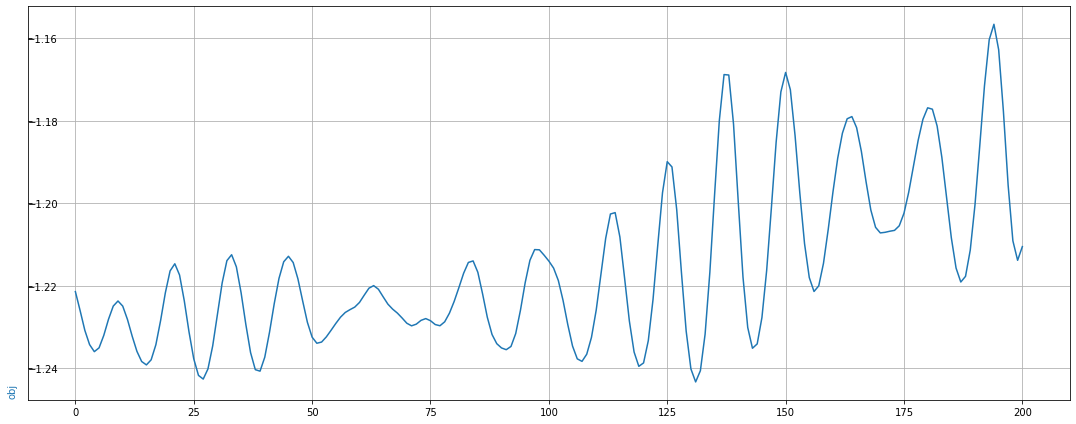

In [16]:
sv.runES(budget)
plot_RDs.close()

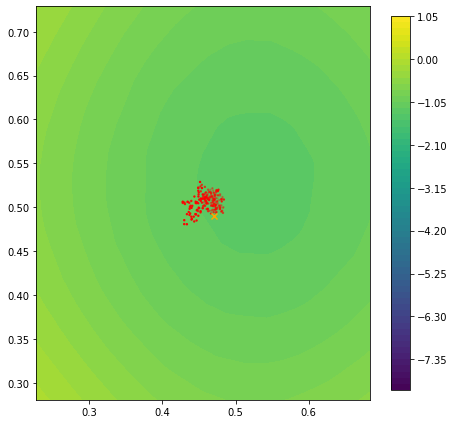

In [17]:
fig, ax = plt.subplots(figsize=(6.5,6))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.scatter(z[:,0],z[:,1],color='r',s=2,alpha=np.linspace(0.2,1,len(z)))
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.2,z[:,0].max()+0.2);
ax.set_ylim(z[:,1].min()-0.2,z[:,1].max()+0.2);
fig.tight_layout()

# SAVO with ES

In [18]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )

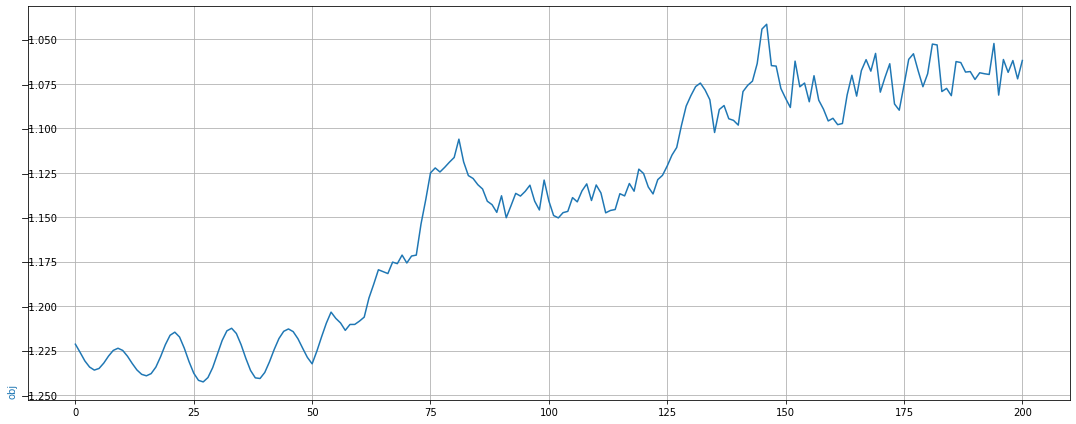

In [19]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=1,lr=lr)
plot_RDs.close()

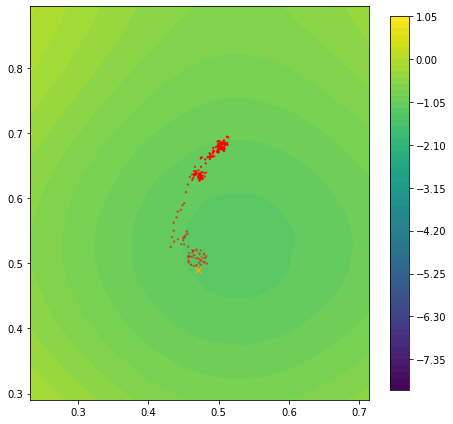

In [20]:
fig, ax = plt.subplots(figsize=(6.5,6))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.scatter(z[:,0],z[:,1],color='r',s=2,alpha=np.linspace(0.2,1,len(z)))
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.2,z[:,0].max()+0.2);
ax.set_ylim(z[:,1].min()-0.2,z[:,1].max()+0.2);
fig.tight_layout()

# SAVO without ES

In [21]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )

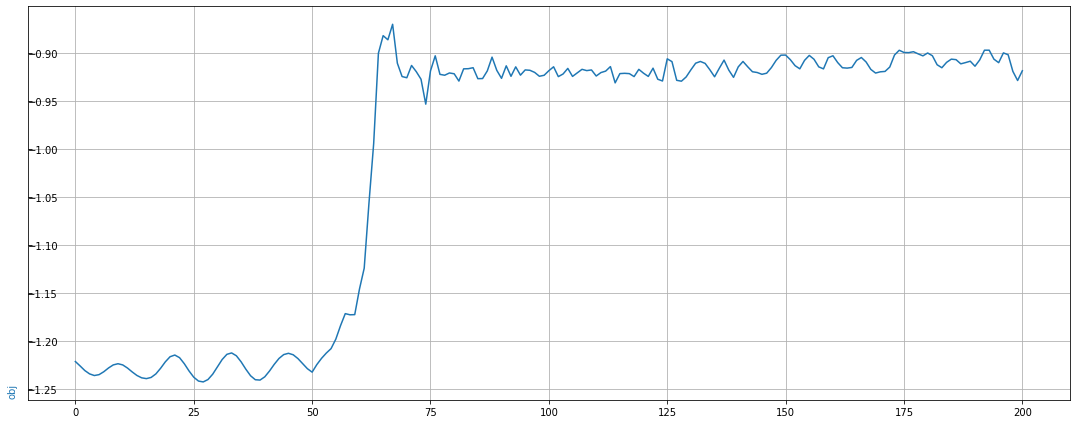

In [22]:
sv.runES(ninit)
sv.run_savo(budget-ninit,lambdaES=0,lr=lr)
plot_RDs.close()

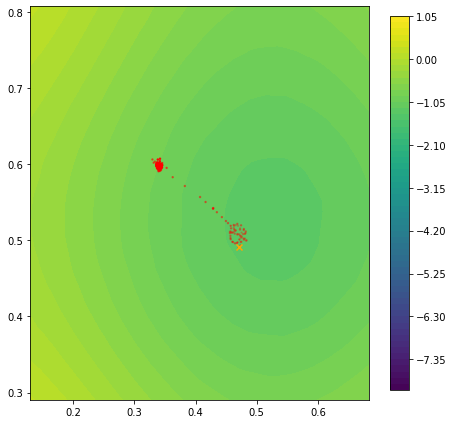

In [23]:
fig, ax = plt.subplots(figsize=(6.5,6))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.scatter(z[:,0],z[:,1],color='r',s=2,alpha=np.linspace(0.2,1,len(z)))
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.2,z[:,0].max()+0.2);
ax.set_ylim(z[:,1].min()-0.2,z[:,1].max()+0.2);
fig.tight_layout()

# BO with moving window.
BO <-- best sample efficiency. But heavy. Not suitable for fast evaluating objective

In [24]:
obj = copy(obj0)
plot_RDs = plot_obj_history( obj.history['objective_RDs'] )
callbacks = [plot_RDs]
def obj_callbacks(x):
    return obj(x)#,callbacks=callbacks)

sv = savo(obj_func= obj_callbacks,
            x0 = x0,
            max_dx = max_dx,
            x_bounds = x_bounds,
            )
sv.runES(ninit)

In [25]:
np.array(sv.history['y']).reshape(-1,1).shape

(51, 1)

In [26]:
# initBO using training data obtained by ES
bo, X_pending, Y_pending_future = pyBO.runBO(
                                    obj_callbacks,  
                                    bounds=obj.decision_bounds,
                                    n_init=ninit,
                                    x0 = np.array(sv.history['x']),
                                    y0 = np.array(sv.history['y']).reshape(-1,1),
                                    budget = ninit,
                                    batch_size=1,                                  
                                    write_log = False)

In [27]:
# BO around current best solution
bound_scaler_hist = []
times = []
bound_scaler = 1
x_best_before = None
for i in range(budget-len(bo.y)):
# for i in range(2):
    x_best,y_best = bo.best_sofar()
    if np.all(x_best_before == x_best):
        bound_scaler*= 2
    else:
        bound_scaler = 1
    x_best_before = x_best
    bound_scaler_hist.append(bound_scaler)
    bounds = np.array(list(zip(x_best-bound_scaler*0.2*max_dx, x_best+bound_scaler*0.2*max_dx)))
    acquisition_func_args = {'beta':1}
    t0 = time.monotonic()
    X_pending, Y_pending_future= bo.loop( 
                                    n_loop=1,  # number of additional optimization interation
                                    func_obj = obj_callbacks,
                                    bounds = bounds,
                                    acquisition_func_args = acquisition_func_args,
                                    X_pending = X_pending, 
                                    Y_pending_future = Y_pending_future,
                                    batch_size = 1,
                                    write_log = False,
                                    )
    times.append(time.monotonic() - t0)

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[████████████████████████████████████████] 100%/100%

[███████████████████████████

KeyboardInterrupt: 

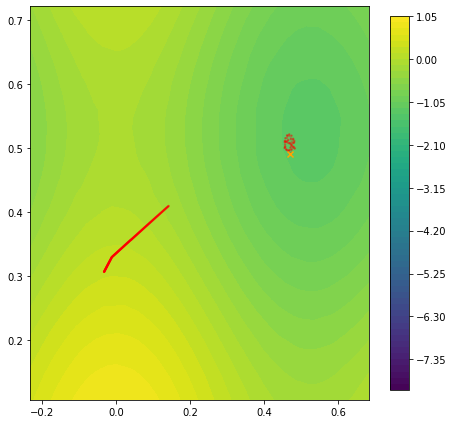

In [28]:
fig, ax = plt.subplots(figsize=(6.5,6))
cs = ax.tricontourf(x[:,0],x[:,1],y, levels=64, cmap="viridis");
fig.colorbar(cs,ax=ax,shrink=0.95)
z = compressor(np.array(obj.history['decision_CSETs']['values']))
ax.scatter(z[:,0],z[:,1],color='r',s=2,alpha=np.linspace(0.2,1,len(z)))
ax.scatter(z[0,0],z[0,1],marker='x',color='orange')
ax.set_xlim(z[:,0].min()-0.2,z[:,0].max()+0.2);
ax.set_ylim(z[:,1].min()-0.2,z[:,1].max()+0.2);
fig.tight_layout()

In [29]:
times

[5.89100000000326,
 3.6089999999967404,
 1.952999999979511,
 2.5160000000032596,
 2.4060000000172295,
 2.3910000000032596,
 2.375,
 2.5,
 2.5310000000172295,
 2.437999999965541,
 2.562000000034459,
 2.625,
 2.9689999999827705,
 2.75,
 2.7660000000032596,
 2.875,
 3.202999999979511,
 3.1560000000172295,
 4.01600000000326,
 3.2959999999729916,
 4.219000000040978,
 3.937999999965541,
 4.0,
 3.2179999999934807,
 5.125,
 172.64100000000326,
 201.98399999999674,
 163.375,
 282.26600000000326,
 126.65600000001723,
 137.7970000000205,
 140.59399999998277,
 108.28100000001723,
 109.89100000000326,
 632.6719999999623,
 135.26500000001397,
 188.1720000000205,
 158.875,
 124.625,
 139.75,
 102.03099999995902,
 66.59400000004098,
 148.53099999995902,
 95.03200000000652,
 145.14000000001397,
 171.96899999998277,
 224.21900000004098,
 184.375,
 224.48399999999674,
 253.7029999999795,
 304.3279999999795,
 356.76600000000326,
 250.26600000000326,
 350.5780000000377,
 249.43699999997625,
 310.25,
 220.2